In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png" or ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreakHis/1 Benign',128))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreakHis/1 Malignant',128))

 58%|█████▊    | 1403/2401 [06:08<04:22,  3.80it/s]


KeyboardInterrupt: ignored

In [ ]:
benign_label=np.zeros(len(benign_train))
malign_label=np.ones(len(malign_train))

In [ ]:
print(len(benign_train),len(malign_train))

2401 5437


In [ ]:
x=np.concatenate((benign_train,malign_train), axis=0)
x=x/255
y=np.concatenate((benign_label,malign_label), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, random_state=11)

In [ ]:
s=np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]


In [ ]:
print(len(x_train),len(x_test))

5251 2587


In [ ]:
x_val=x_test
y_val=y_test

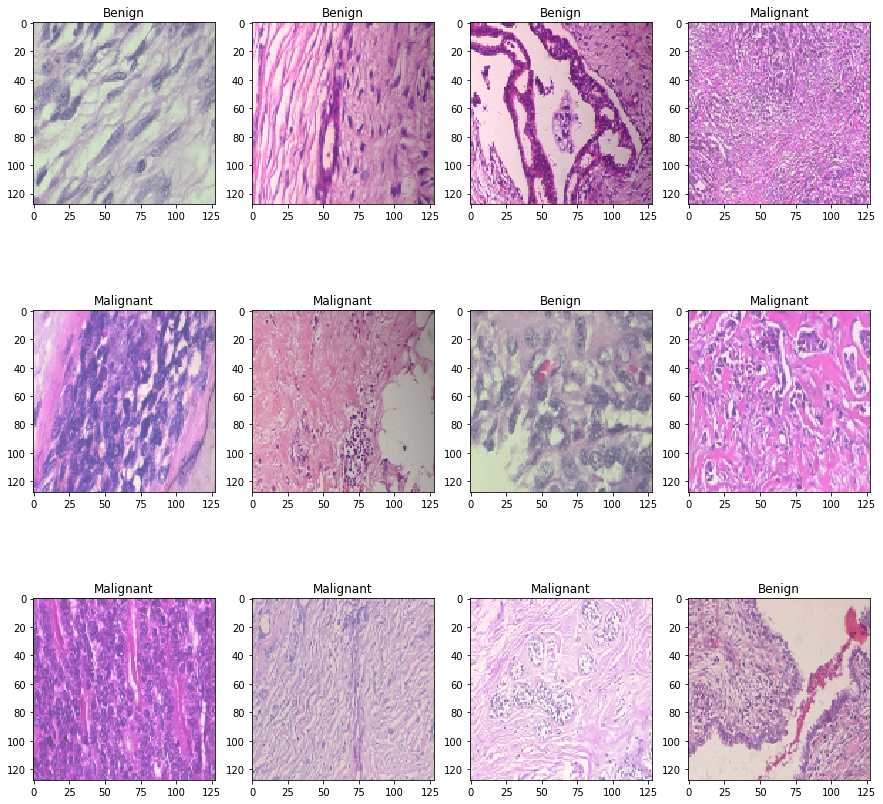

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,  
    )

In [ ]:
def build_model():
    model = Sequential()
    model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(128,128,3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    
    model.compile(
        loss= 'binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
Total params: 18,329,664
Trainable params: 18,096,768
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/content/drive/MyDrive/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
features_train = model.predict(x_train)
features_val = model.predict(x_val)
features_test = model.predict(x_test)

print(features_train.shape,features_val.shape,features_test.shape)

(5251, 1920) (2587, 1920) (2587, 1920)


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
classifier = svm.fit(features_train,y_train)

In [ ]:
svm.score(features_train,y_train)

0.9415349457246239

In [ ]:
svm.score(features_val,y_val)

0.880556629300348

In [ ]:
svm.score(features_test,y_test)

0.880556629300348

In [ ]:
predictions = svm.predict(features_test)

In [ ]:
class_names=['Benign','Malignant']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = pd.DataFrame(confusion_matrix(y_val, predictions), index=class_names, columns=class_names)

In [ ]:
labels = ['benign', 'malignant']

In [ ]:
cm_new=confusion_matrix(y_val,predictions)
print(cm_new)

[[ 597  221]
 [  88 1681]]


Confusion matrix, without normalization
[[ 597  221]
 [  88 1681]]


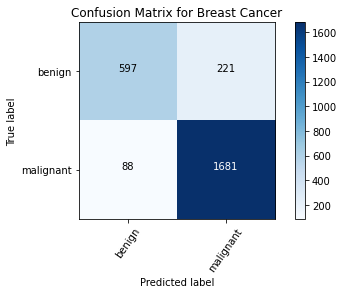

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm_new, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

In [ ]:
print(classification_report(y_val, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.87      0.73      0.79       818
   Malignant       0.88      0.95      0.92      1769

    accuracy                           0.88      2587
   macro avg       0.88      0.84      0.86      2587
weighted avg       0.88      0.88      0.88      2587

